## PNP-VQA: Inference Demo

In [2]:
pip install salesforce-lavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 27.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━

In [1]:
import torch
import requests
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from lavis.common.gradcam import getAttMap
from lavis.models import load_model_and_preprocess

### Load an example image and question

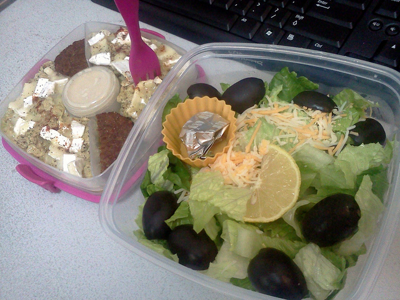

What is the black objects on the salad called?


In [2]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/projects/pnp-vqa/demo.png'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
# raw_image = Image.open("./demo.png").convert("RGB")
display(raw_image.resize((400, 300)))
question = "What is the black objects on the salad called?"
print(question)

In [3]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load PNP-VQA model

In [4]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="pnp_vqa", model_type="base", is_eval=True, device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 3.43G/3.43G [00:57<00:00, 64.1MB/s]
100%|██████████| 1.66G/1.66G [00:28<00:00, 62.0MB/s]


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

torch.save(model.state_dict(), '/content/drive/MyDrive/pnpmodel')


In [ ]:

from google.colab import files

# Download the saved model file
files.download('/content/drive/MyDrive/pnpmodel')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Preprocess image and text inputs

In [6]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
question = txt_processors["eval"](question)

samples = {"image": image, "text_input": [question]}

### PNP-VQA utilizes 3 submodels to perform VQA:
#### 1. Image-Question Matching
Compute the relevancy score of image patches with respect to the question using GradCAM

In [ ]:
samples = model.forward_itm(samples=samples)

Question: what is the black objects on the salad called?


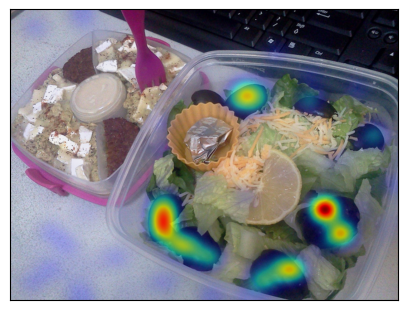

In [ ]:
# Gradcam visualisation
dst_w = 720
w, h = raw_image.size
scaling_factor = dst_w / w

resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
norm_img = np.float32(resized_img) / 255
gradcam = samples['gradcams'].reshape(24,24)

avg_gradcam = getAttMap(norm_img, gradcam, blur=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(avg_gradcam)
ax.set_yticks([])
ax.set_xticks([])
print('Question: {}'.format(question))

#### 2. Image Captioning
Generate question-guided captions based on the relevancy score

In [ ]:
samples = model.forward_cap(samples=samples, num_captions=50, num_patches=20)
print('Examples of question-guided captions: ')
samples['captions'][0][:5]

Examples of question-guided captions: 


['a plastic container of a salad with some fruit',
 'a couple of containers filled with a salad and a cup',
 'avocado fruits and salad next to olives are ready to eat',
 'a close up of a salad in a container with fruit and vegetables',
 'a bowl with black olives, green salad and a lemon slice']

#### 3. Question Answering
Answer the question by using the captions

In [ ]:
pred_answers = model.forward_qa(samples, num_captions=50)
print('Question: {} \nPredicted answer: {}'.format(question, pred_answers[0]))

Question: what is the black objects on the salad called? 
Predicted answer: olives


### Generate answer by calling `predict_answers()` directly


In [ ]:
pred_answers, caption, gradcam = model.predict_answers(samples, num_captions=50, num_patches=20)
print('Question: {} \nPredicted answer: {}'.format(question, pred_answers[0]))

Question: what is the black objects on the salad called? 
Predicted answer: olives


In [7]:
import json

# Load the questions
# Opening JSON file
f = open('/content/drive/MyDrive/OpenEnded_abstract_v002_val2017_questions.json')

# Return JSON object as dictionary
data_questions = json.load(f)
print(data_questions.keys())
with open('/content/drive/MyDrive/OpenEnded_abstract_v002_val2017_questions.json', 'r') as file:
    questions = json.load(file)

# Load the annotations
with open('/content/drive/MyDrive/abstract_v002_val2017_annotations.json', 'r') as file:
    annotations = json.load(file)

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])


In [8]:
from os import listdir
from os.path import isfile, join
from tqdm.auto import tqdm
import re
from typing import Optional

filename_re = re.compile(r".*(\d{12})\.((jpg)|(png))")

# source: https://github.com/allenai/allennlp-models/blob/a36aed540e605c4293c25f73d6674071ca9edfc3/allennlp_models/vision/dataset_readers/vqav2.py#L141
def id_from_filename(filename: str) -> Optional[int]:
    match = filename_re.fullmatch(filename)
    if match is None:
        return None
    return int(match.group(1))

# root at which all images are stored
root = '/content/drive/MyDrive/scene_img_abstract_v002_binary_val2017-20240517T114432Z-001/scene_img_abstract_v002_binary_val2017/output_directory'
file_names = [f for f in tqdm(listdir(root)) if isfile(join(root, f))]
filename_to_id = {root + "/" + file: id_from_filename(file) for file in file_names}
id_to_filename = {v:k for k,v in filename_to_id.items()}

root = '/content/drive/MyDrive/scene_img_abstract_v002_binary_val2017-20240517T114432Z-001/scene_img_abstract_v002_binary_val2017/output_directory'
file_names = [f for f in tqdm(listdir(root)) if isfile(join(root, f))]
filename_to_id = {root + "/" + file: id_from_filename(file) for file in file_names}
id_to_filename = {v:k for k,v in filename_to_id.items()}

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

In [9]:
from PIL import Image

# len(questions['questions'])
tp=0
fn=0
fp=0
tn=0
count =0;
num=1000
for i in range(num):
  sample_question = questions['questions'][i]
  sample_annotation = annotations['annotations'][i]
  path = id_to_filename[sample_question['image_id']]

  raw_image = Image.open(path).convert("RGB")
  question = sample_question['question']
  image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
  question = txt_processors["eval"](question)
  samples = {"image": image, "text_input": [question]}
  pred_answers, caption, gradcam = model.predict_answers(samples, num_captions=50, num_patches=20)

  answer=pred_answers[0]
  if (answer == sample_annotation['multiple_choice_answer']):

    count = count + 1;
    if(sample_annotation['multiple_choice_answer']=='yes'):
      tp=tp+1
    else:
      tn=tn+1
  else:
    if(sample_annotation['multiple_choice_answer']=='yes'):
      fn=fn+1
    else:
      fp=fp+1

print(count)
pre=tp/(tp+fp)
Recall= tp/(tp+fn)
print('Accuracy:', 100*count/num)
print('precision:', tp/(tp+fp))
print('Recall:', tp/(tp+fn))
print('F1 Score:', 2*((pre*Recall)/(pre+Recall)))

558
Accuracy: 55.8
precision: 0.531496062992126
Recall: 0.569620253164557
F1 Score: 0.54989816700611
